<a href="https://colab.research.google.com/github/camiloodiaboalves/ProjetoKNNRESTICGrupo2/blob/main/KNN_Influencers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Influencers com KNN para Classificação e Regressão

**Grupo 02**

Caio Franco

Camilo Alves Mascarenhas

In [ ]:
#bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Pré Processamento

Atributos:


*   rank: rank do influencer com base no número de seguidores
*   channel_info: nome de usuário no instagram
*   influence_score: Calculado com base em mensões, importância e popularidade esse valor reflete a influência de cada influencer
*   posts: número total de posts no instagram
*   followers: Número de seguidores
*   avg_likes: Média de likes por post (total_likes/total_posts)
*   60_day_eng_rate: Taxa de engajamento dos últimos 60 dias do instagrammer como fração dos engajamentos que ele fez até agora
*   new_post_avg_like: Média de Likes em posts novos
*   total_likes: Total de likes que o influencer tem nos seus posts
*    country: País ou região do influencer.





In [ ]:
#Dataset
file_path = '/content/sample_data/top_insta_influencers_data.csv'
influencers = pd.read_csv(file_path)
influencers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rank               200 non-null    int64 
 1   channel_info       200 non-null    object
 2   influence_score    200 non-null    int64 
 3   posts              200 non-null    object
 4   followers          200 non-null    object
 5   avg_likes          200 non-null    object
 6   60_day_eng_rate    200 non-null    object
 7   new_post_avg_like  200 non-null    object
 8   total_likes        200 non-null    object
 9   country            138 non-null    object
dtypes: int64(2), object(8)
memory usage: 15.8+ KB


In [ ]:
#Pré Processamento

#Função para remover os indicadores "k", "m" e "b"
def remove_indic(value):
  if isinstance(value,str):
    if 'k' in value:
      return float(value.replace('k','')) * 1000
    elif 'm' in value:
      return float(value.replace('m','')) * 1000000
    elif 'b' in value:
      return float(value.replace('b','')) * 1000000000
  else:
    return value
#Criando DataSet
dataset = pd.DataFrame()

dataset['rank'] = influencers['rank']
dataset['account'] = influencers['channel_info']
dataset['influence'] = influencers['influence_score']
dataset['posts'] = influencers['posts'].apply(remove_indic)
dataset['followers'] = influencers['followers'].apply(remove_indic)
dataset['avg_likes'] = influencers['avg_likes'].apply(remove_indic)
dataset['eng_rate'] = influencers['60_day_eng_rate'].replace("%", "", regex=True)
dataset['eng_rate'] = dataset['eng_rate'].astype(float)
dataset['avg_new_likes'] = influencers['new_post_avg_like'].apply(remove_indic)
dataset['total_likes'] = influencers['total_likes'].apply(remove_indic)
dataset['country'] = influencers['country']

No desafio foi feita uma observação sobre a converção dos países em dados numéricos, optei por fazer uma destinção pela classificação de desenvolvimento. Os países serão classificados como:
0 - subdesenvolvidos
1 - em desenvolvimento
2 - desenlvolvidos



In [ ]:
dataset['country'].unique()

array(['Spain', 'United States', nan, 'Canada', 'Brazil', 'Netherlands',
       'United Kingdom', 'India', 'Uruguay', 'Turkey', 'Indonesia',
       'Colombia', 'France', 'Australia', 'Italy', 'United Arab Emirates',
       'Puerto Rico', "CÃ´te d'Ivoire", 'Anguilla', 'Switzerland',
       'Sweden', 'British Virgin Islands', 'Czech Republic', 'Mexico',
       'Germany', 'Russia'], dtype=object)

In [ ]:
country_tranform = {
    "Spain": 2,"United States": 2,"Canada": 2,"Netherlands": 2,
    "United Kingdom": 2,"France": 2,"Australia":2,"Italy": 2,
    "Switzerland":2,"Sweden": 2,"Germany": 2, "Portugal":2,
     "Belgium":2,"Norway":2,

    "Brazil": 1,"Turkey": 1,"India":1,"Indonesia":1,"Colombia": 1,
    "Uruguay": 1,"Mexico": 1,"Russia":1,"United Arab Emirates":1,
    "Czech Republic":1, "Argentina": 1,"Chile":1, "Ecuador": 1,
    "Paraguay": 1,

    "Anguilla":0,"British Virgin Islands":0,"Puerto Rico": 0,
    "CÃ´te d'Ivoire":0,"Venezuela": 0,
}
dataset['country'] = dataset['country'].map(country_tranform)

Algumas Observações:


*   Porto Rico é território estadunidence, mas por conta da sua situação econômica ruim, está como "subdesenvolvido"

*   Apesar do seu histórico como país em desenvolvimento, a Venezuela, também pela sua situação econômica, e humanitária, está como "subdesenvolvido".



## Análise Exploratória

In [ ]:
#Procurando valores nulos
dataset.isna().sum()

,0
rank,0
account,0
influence,0
posts,0
followers,0
avg_likes,0
eng_rate,1
avg_new_likes,8
total_likes,0
country,62


In [ ]:
dataset.head()

,rank,account,influence,posts,followers,avg_likes,eng_rate,avg_new_likes,total_likes,country
0,1,cristiano,92,3300.0,475800000.0,8700000.0,1.39,6500000.0,2.900000e+10,2.0
1,2,kyliejenner,91,6900.0,366200000.0,8300000.0,1.62,5900000.0,5.740000e+10,2.0
2,3,leomessi,90,890.0,357300000.0,6800000.0,1.24,4400000.0,6.000000e+09,NaN
3,4,selenagomez,93,1800.0,342700000.0,6200000.0,0.97,3300000.0,1.150000e+10,2.0
4,5,therock,91,6800.0,334100000.0,1900000.0,0.20,665300.0,1.250000e+10,2.0


In [ ]:
dataset.tail()

,rank,account,influence,posts,followers,avg_likes,eng_rate,avg_new_likes,total_likes,country
195,196,iambeckyg,71,2300.0,33200000.0,623800.0,1.40,464700.0,1.400000e+09,2.0
196,197,nancyajram,81,3800.0,33200000.0,390400.0,0.64,208000.0,1.500000e+09,2.0
197,198,luansantana,79,770.0,33200000.0,193300.0,0.26,82600.0,1.492000e+08,1.0
198,199,nickjonas,78,2300.0,33000000.0,719600.0,1.42,467700.0,1.700000e+09,2.0
199,200,raisa6690,80,4200.0,32800000.0,232200.0,0.30,97400.0,9.691000e+08,1.0


In [ ]:
dataset.describe()

,rank,influence,posts,followers,avg_likes,eng_rate,avg_new_likes,total_likes,country
count,200.000000,200.000000,200.000000,2.000000e+02,2.000000e+02,199.000000,1.920000e+02,2.000000e+02,138.000000
mean,100.500000,81.820000,3499.850000,7.740950e+07,1.787104e+06,1.902010,1.258471e+06,3.658112e+09,1.630435
std,57.879185,8.878159,3475.828158,7.368727e+07,2.193359e+06,3.329719,1.879979e+06,5.561939e+09,0.541370
min,1.000000,22.000000,10.000000,3.280000e+07,6.510000e+04,0.010000,7.700000e+03,1.830000e+07,0.000000
25%,50.750000,80.000000,947.500000,4.000000e+07,5.044000e+05,0.410000,2.214500e+05,9.968500e+08,1.000000
50%,100.500000,84.000000,2100.000000,5.005000e+07,1.100000e+06,0.880000,5.722000e+05,2.000000e+09,2.000000
75%,150.250000,86.000000,5025.000000,6.890000e+07,2.100000e+06,2.035000,1.400000e+06,3.900000e+09,2.000000
max,200.000000,93.000000,17500.000000,4.758000e+08,1.540000e+07,26.410000,1.260000e+07,5.740000e+10,2.000000


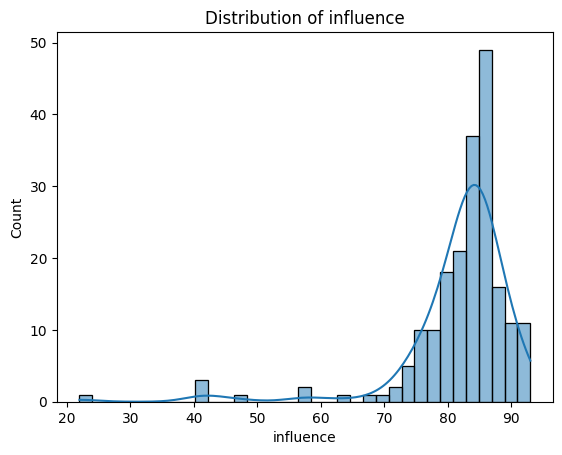

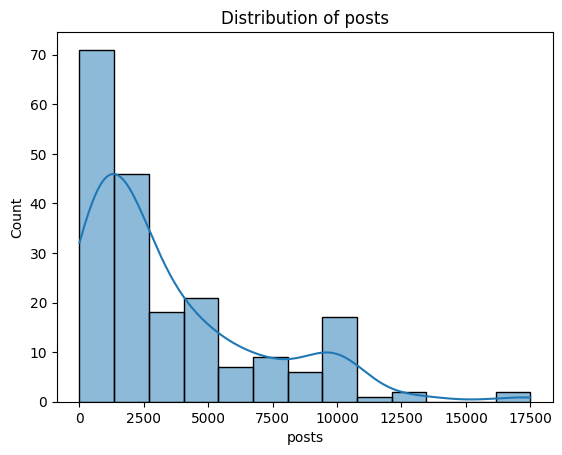

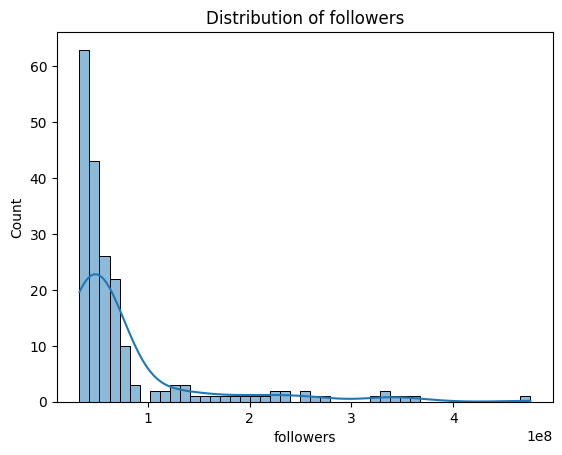

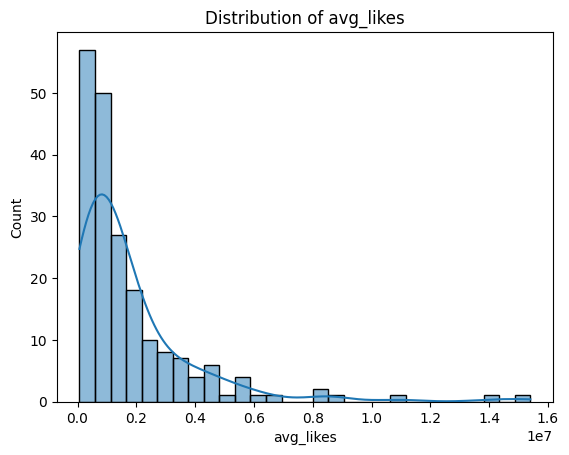

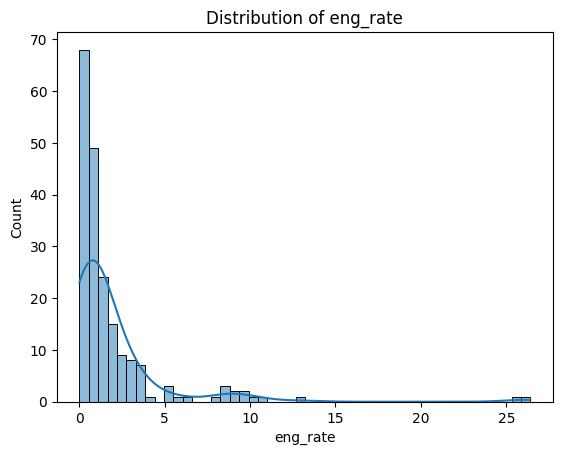

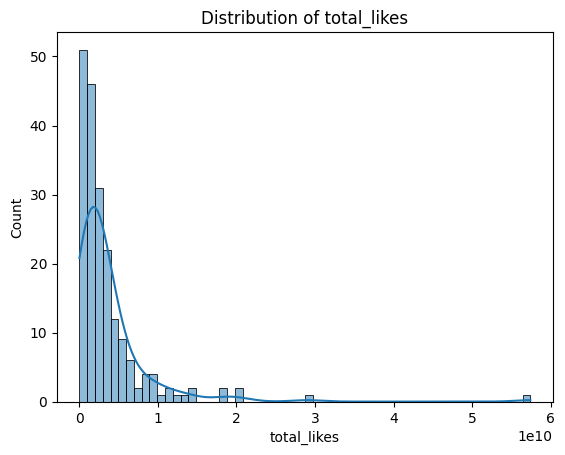

In [ ]:
for col in ['influence', 'posts', 'followers', 'avg_likes','eng_rate','total_likes']:
    sns.histplot(dataset[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [ ]:
#Dataset sem a coluna 'account'
dataset_num = dataset.drop(columns=['account'])

In [ ]:
variability = dataset_num.select_dtypes(include=['float64', 'int64']).std() / dataset_num.mean()
print("Variabilidade (CV):")
print(variability.sort_values(ascending=False))

Variabilidade (CV):
eng_rate         1.750632
total_likes      1.520439
avg_new_likes    1.493859
avg_likes        1.227326
posts            0.993136
followers        0.951915
rank             0.575912
country          0.332040
influence        0.108508
dtype: float64


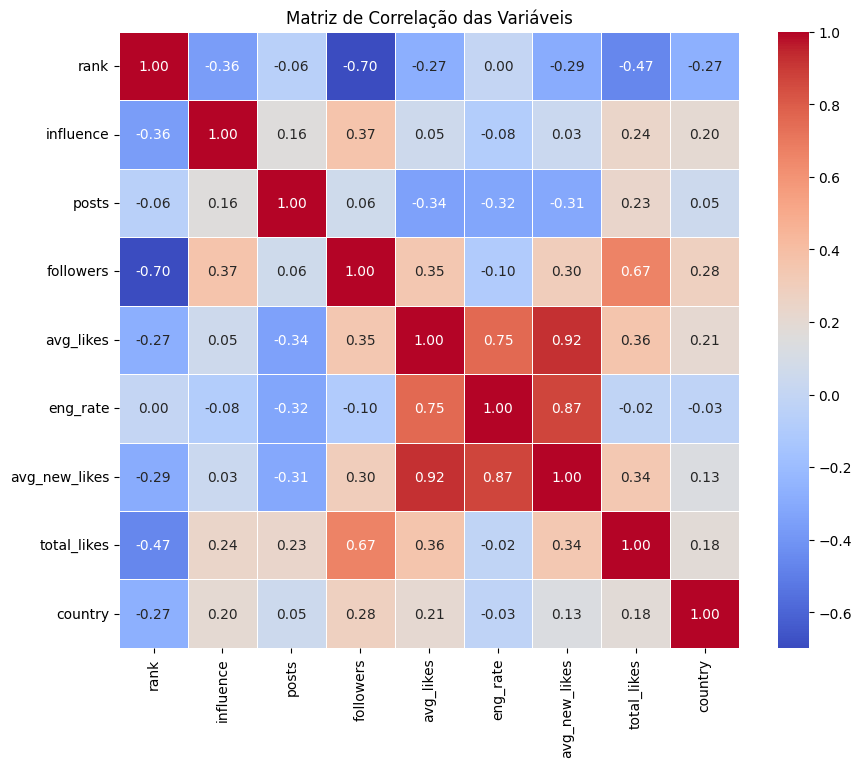

In [ ]:
#Criando Matrix de Correlação
mat_cor = dataset_num.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(mat_cor, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação das Variáveis")
plt.show()

1.   Os likes em posts recentes estão fortemente relacionados com a média geral de likes. Deve a ver uma relação como os likes novos possuírem em média X% da média de likes.
1.   Também vemos como o engajamento está correlacionado com a média de likes e ainda mais com a média de likes em posts novos.
3.   O número de seguidores parece também estar atrelado aos likes, além da influência.
4.   Apesar do esperado ser que o engajamento tenha um grande papel na influência, pela matriz de correlação vemos que o número de seguidores é mais importante nesse quesito.
5.   Talvez pelo grande número de valores nulos, 'country' não parece ter muita correlação com nenhum



Resumindo, acredito que é possível dizer que as variáveis mais importantes são número de likes e taxa de engajamento. Porém o número de seguidores também parece ter importância na influência de um influencer.

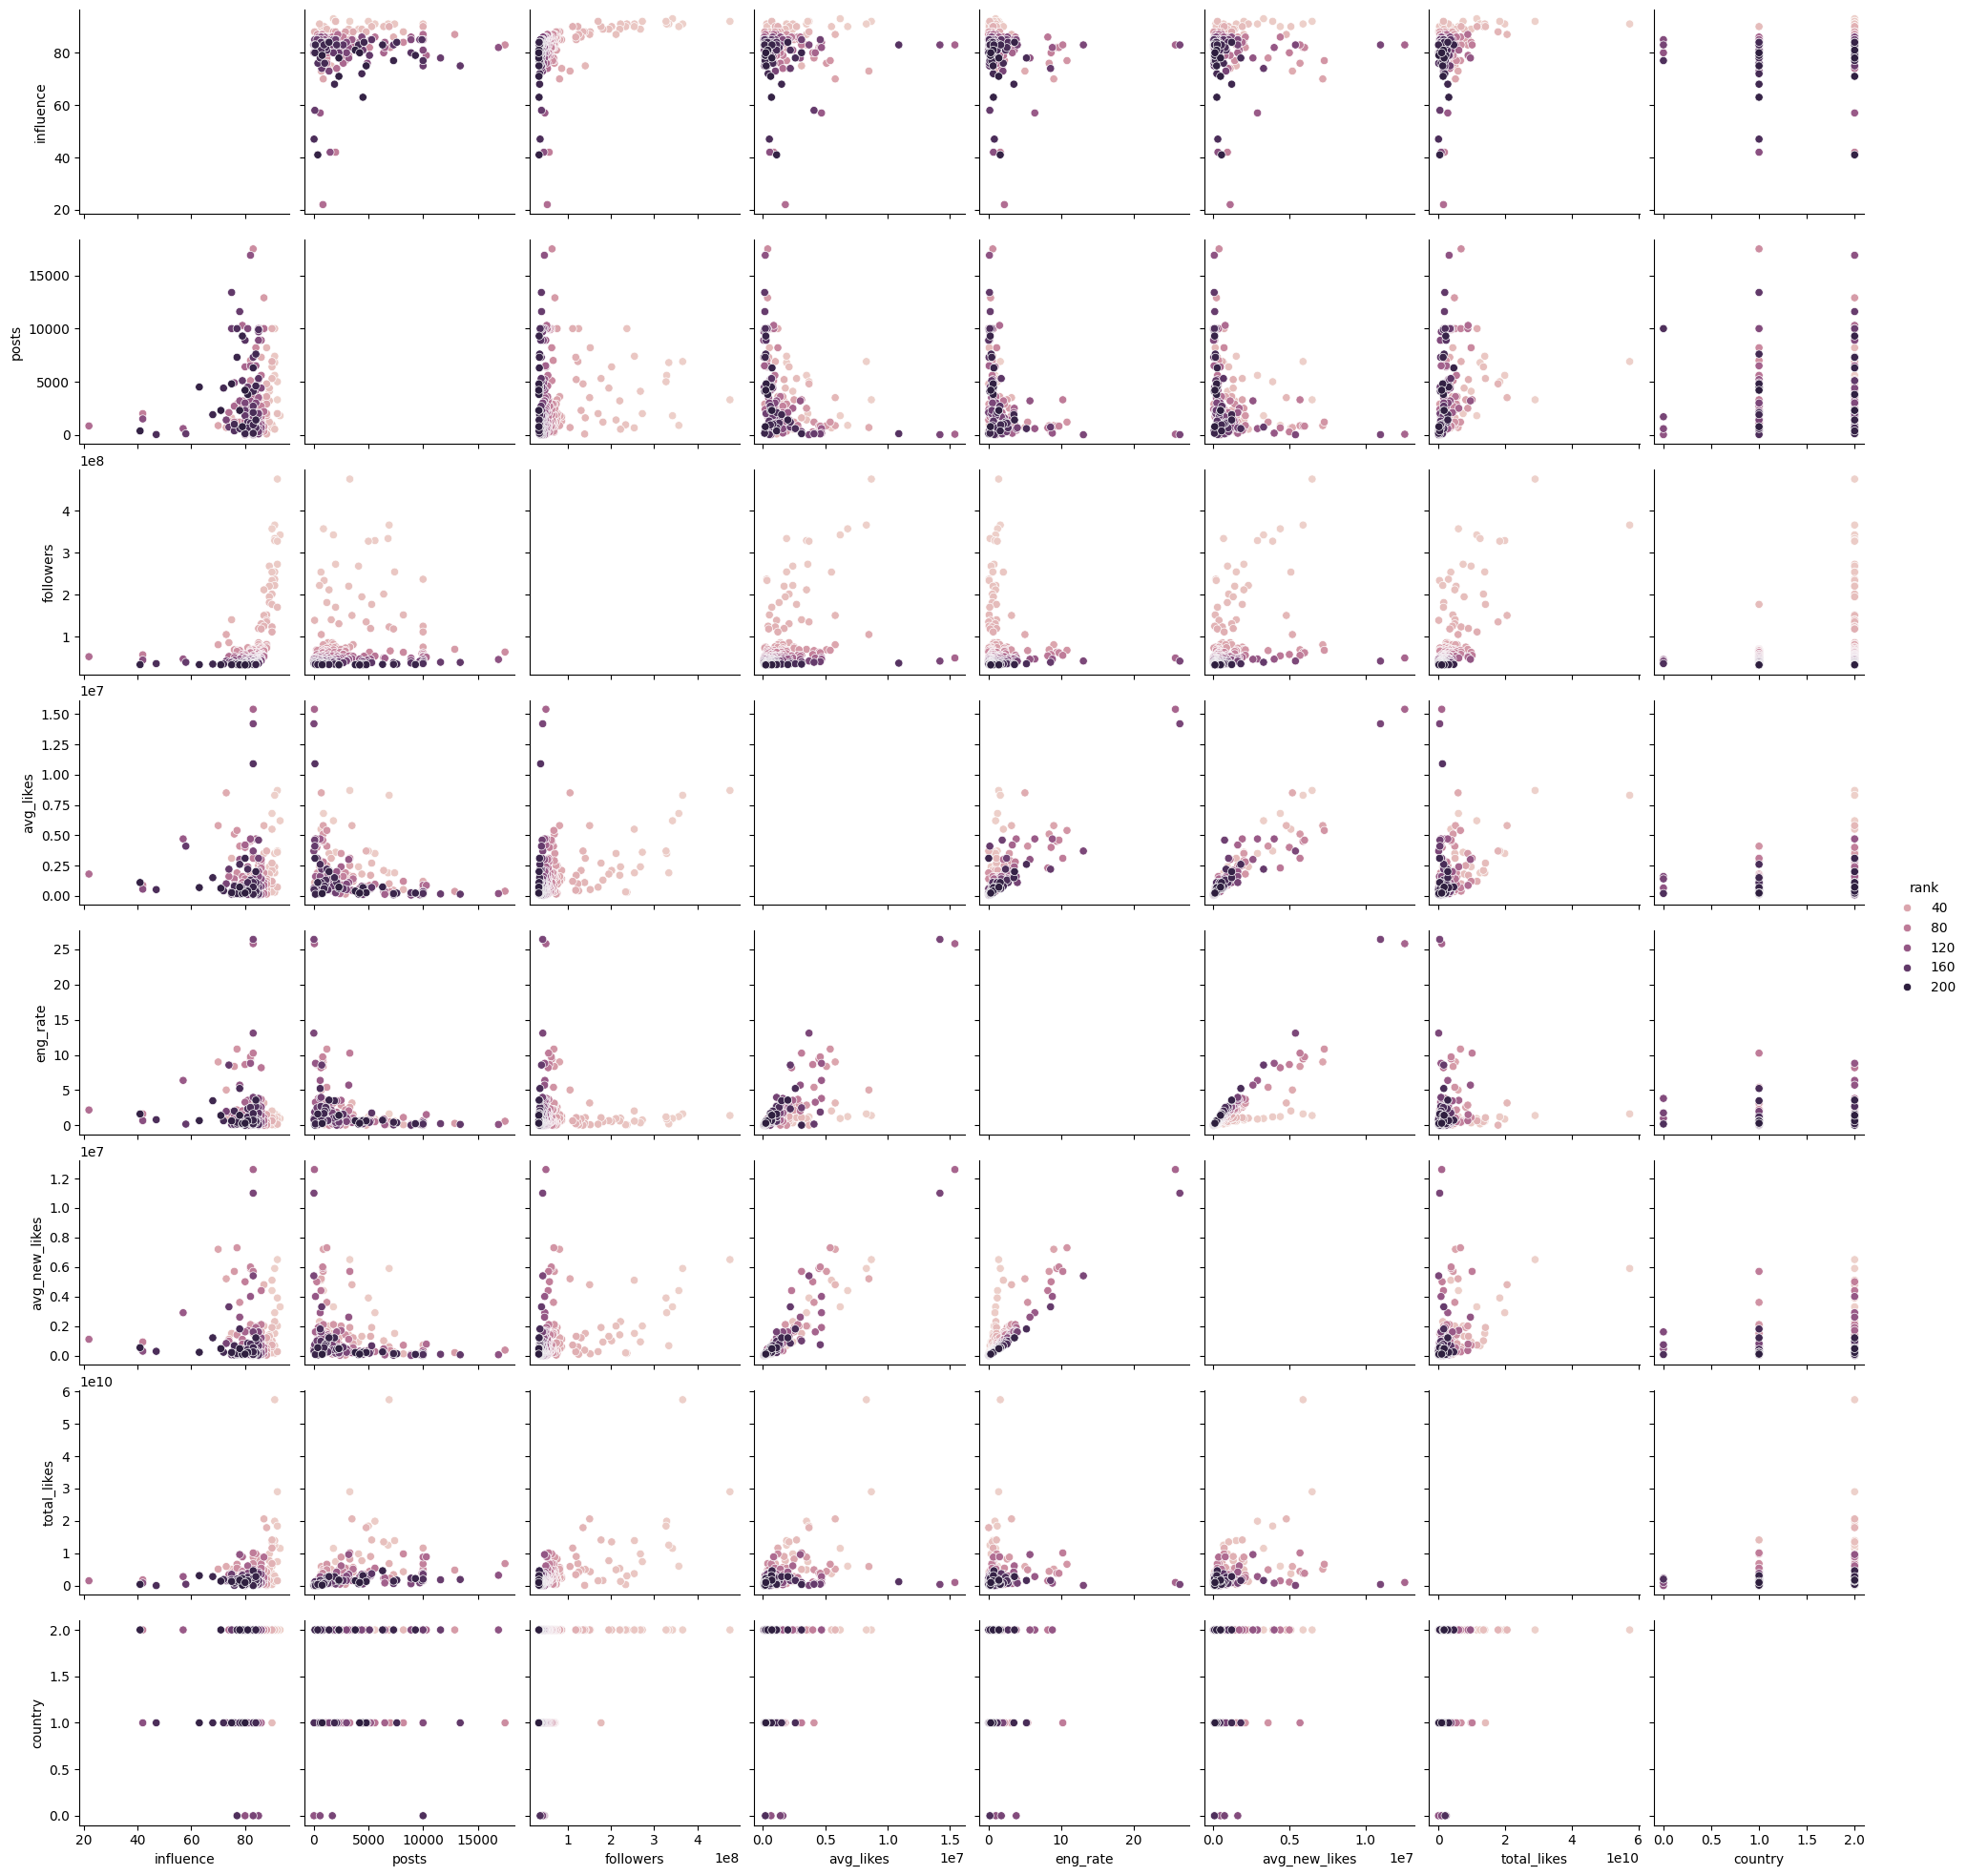

In [ ]:
sns.pairplot(dataset_num, hue='rank')
plt.show()

## Otimização

In [ ]:
#Procurando valores duplicados
dataset.duplicated().sum()

0

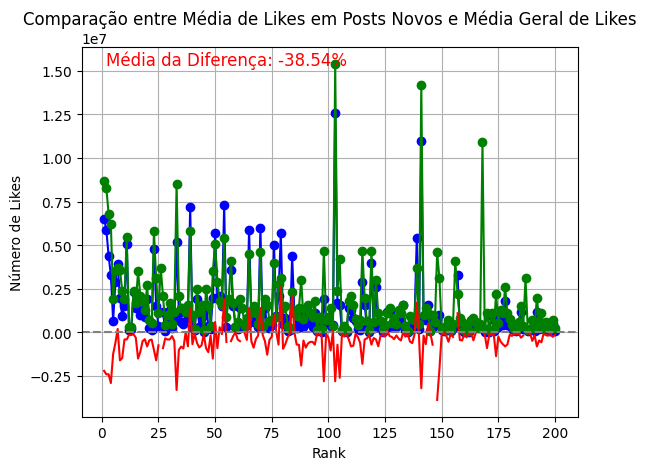

In [ ]:
# Gráfico de linha para 'Média likes em posts novos','Média likes' e 'Diferença média entre os dois'
plt.plot(dataset['rank'], dataset['avg_new_likes'], color='blue', marker='o', label='Média likes em posts novos')
plt.plot(dataset['rank'], dataset['avg_likes'], color='green',marker='o', label='Média likes')
plt.plot(dataset['rank'], dataset['avg_new_likes'] - dataset['avg_likes'], color='red', label='Diferença (Novos - Geral)')

diferenca_percentual = ((dataset['avg_new_likes'] - dataset['avg_likes']) / dataset['avg_likes']) * 100
media_diferenca_percentual = diferenca_percentual.mean()
plt.text(x=0.05, y=0.95, s=f'Média da Diferença: {media_diferenca_percentual:.2f}%',
         transform=plt.gca().transAxes, fontsize=12, color='red')

plt.xlabel("Rank")
plt.ylabel("Número de Likes")
plt.title("Comparação entre Média de Likes em Posts Novos e Média Geral de Likes")
plt.axhline(y=0, color='gray', linestyle='--', label='Paridade (Diferença = 0)')
plt.grid()
plt.show()


O gráfico indica que, em média, os posts novos tem 38,54% likes a menos que posts mais antigos. Usarei essa métrica para preencher os valores de avg_new_likes que estão faltando. E removerei as linhas que não possuem eng_rate ou country

In [ ]:
dataset['avg_new_likes'] = dataset['avg_new_likes'].fillna(dataset['avg_likes'] * 0.6146)
dataset.dropna(inplace=True)
dataset_num = dataset.drop(columns=['account'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 0 to 199
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rank           138 non-null    int64  
 1   account        138 non-null    object 
 2   influence      138 non-null    int64  
 3   posts          138 non-null    float64
 4   followers      138 non-null    float64
 5   avg_likes      138 non-null    float64
 6   eng_rate       138 non-null    float64
 7   avg_new_likes  138 non-null    float64
 8   total_likes    138 non-null    float64
 9   country        138 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 11.9+ KB


In [ ]:
dataset_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 0 to 199
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rank           138 non-null    int64  
 1   influence      138 non-null    int64  
 2   posts          138 non-null    float64
 3   followers      138 non-null    float64
 4   avg_likes      138 non-null    float64
 5   eng_rate       138 non-null    float64
 6   avg_new_likes  138 non-null    float64
 7   total_likes    138 non-null    float64
 8   country        138 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 10.8 KB


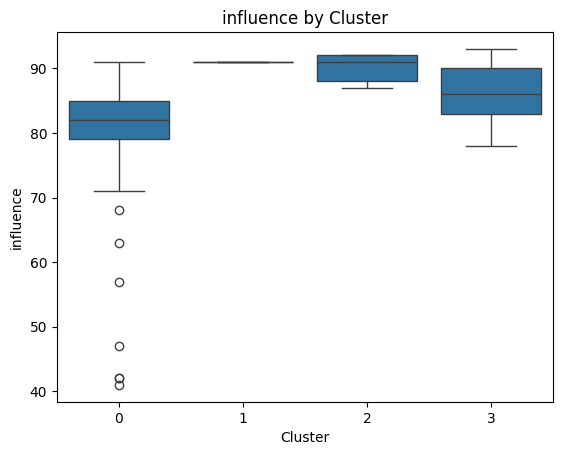

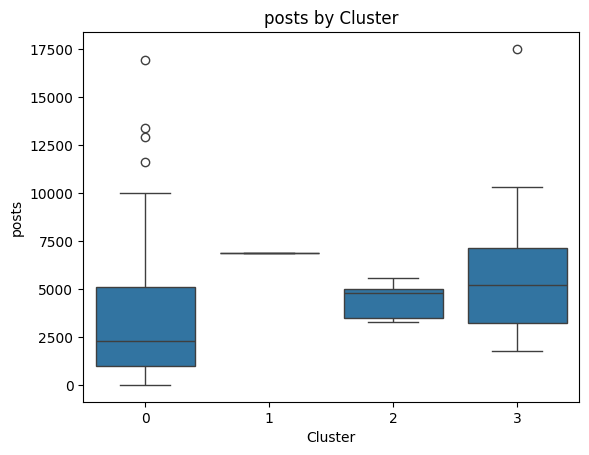

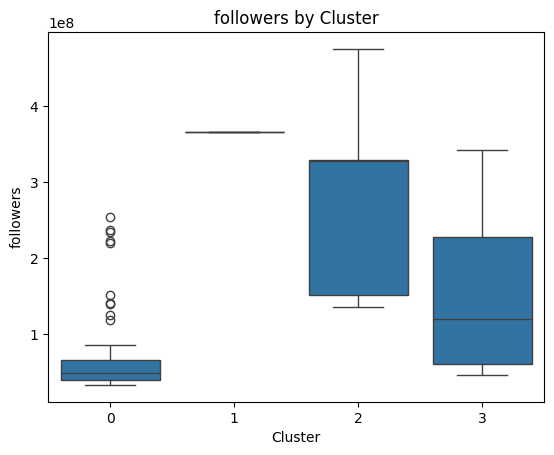

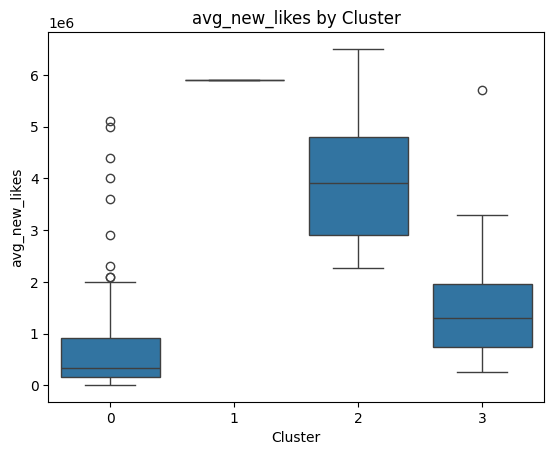

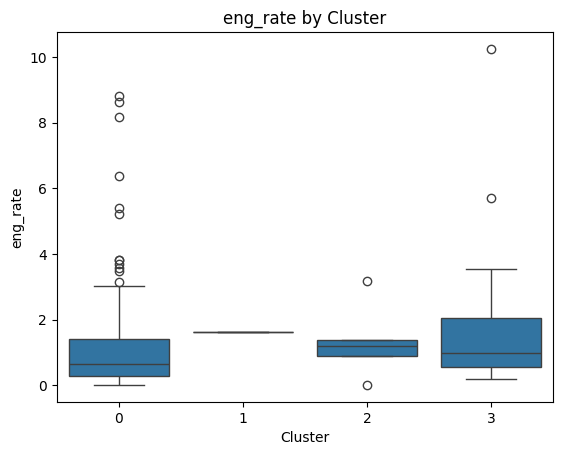

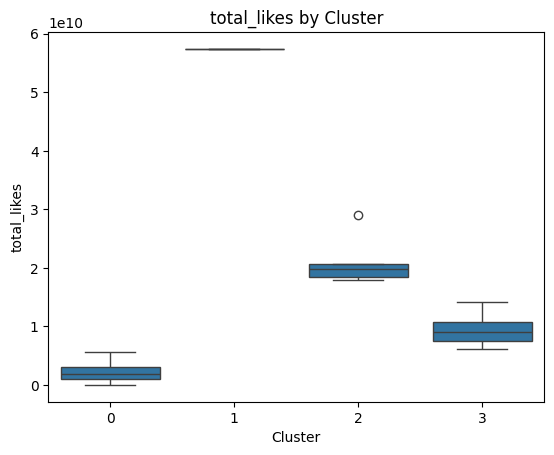

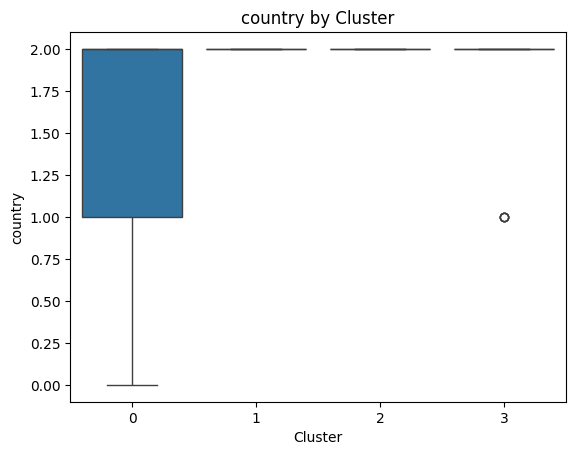

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(dataset_num)
dataset_cluster = dataset_num
dataset_cluster['Cluster'] = clusters

# Verificar importância visualizando distribuições por cluster
for col in ['influence', 'posts', 'followers', 'avg_new_likes','eng_rate','total_likes','country']:

  sns.boxplot(x='Cluster', y=col, data=dataset_cluster)
  plt.title(col+" by Cluster")
  plt.show()

Variância explicada por componente:
[9.99918228e-01 8.17170724e-05]


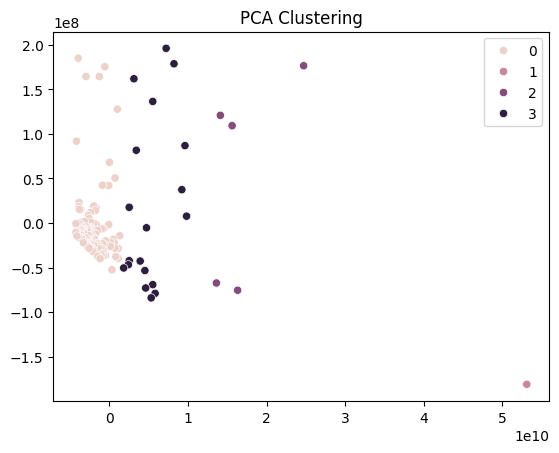

In [ ]:
#
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dataset_num)
print("Variância explicada por componente:")
print(pca.explained_variance_ratio_)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],hue=clusters)
plt.title("PCA Clustering")
plt.show()

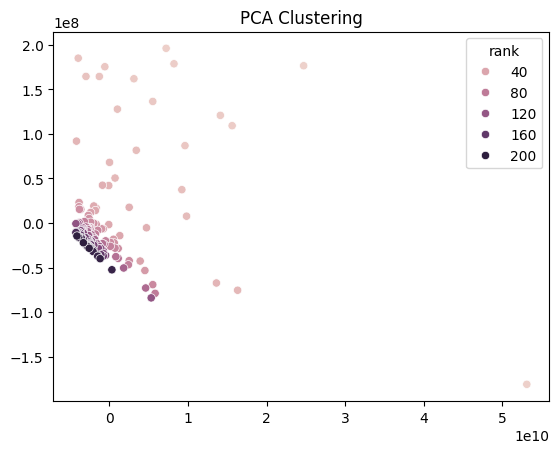

In [ ]:
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],hue=dataset_num['rank'])
plt.title("PCA Clustering")
plt.show()

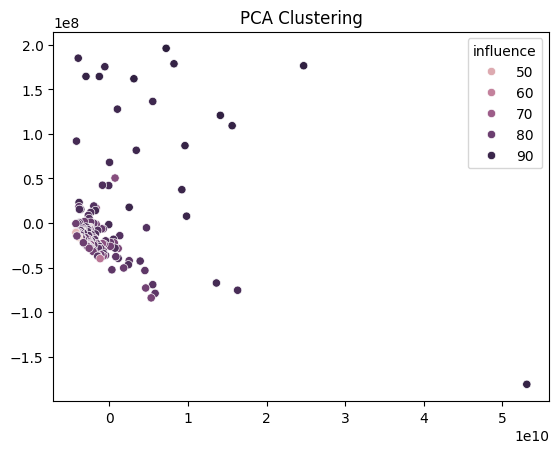

In [ ]:
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],hue=dataset_num['influence'])
plt.title("PCA Clustering")
plt.show()

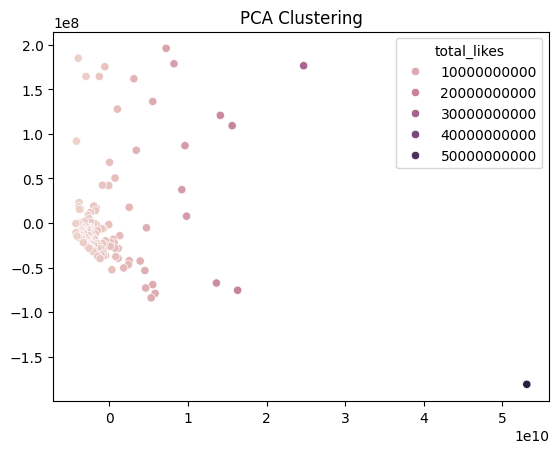

In [ ]:
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],hue=dataset_num['total_likes'])
plt.title("PCA Clustering")
plt.show()

Pela análise dos agrumentos feitos, pudemos indentificar 4 grupos diferentes e bem separados (também fiz com 3 grupos e deu certo igualmente). Em ordem de 0-3 podemos ver que os ranks, total_likes e outras variáveis importantes mostram essa separaçao dos influenciadores mais famosos.

Foi possível, através dos boxplot, observar claramente a existência de alguns outliers, que serão removidos para melhorar o desempenho do modelo.

In [ ]:
#Removendo outliers em variáveis importantes
dataset=dataset[dataset['total_likes'] <= 25000000000]
dataset=dataset[dataset['influence'] >= 70]
dataset=dataset[dataset['eng_rate'] <= 2.5]
dataset_num = dataset.drop(columns='account')

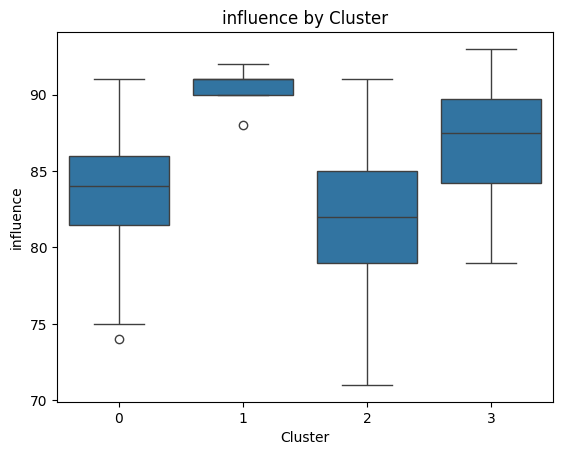

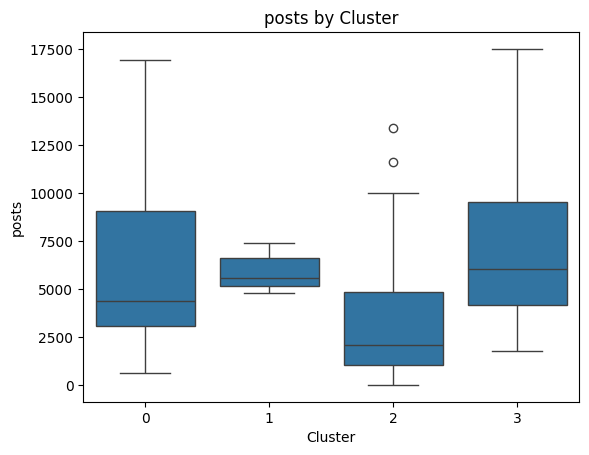

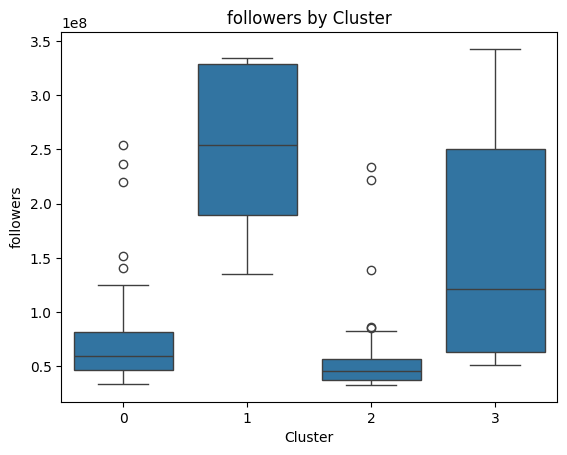

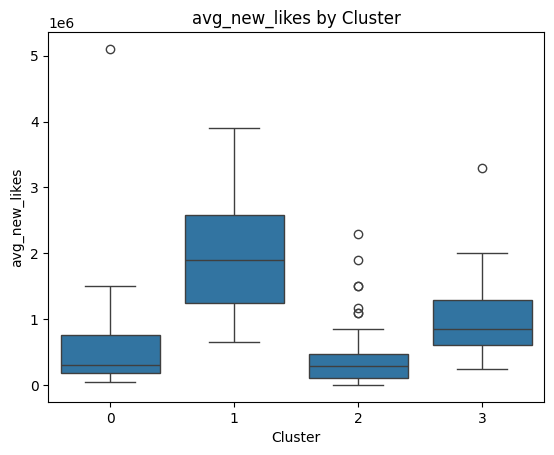

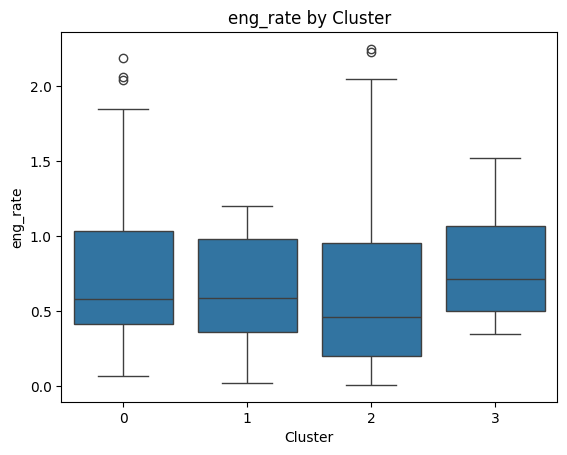

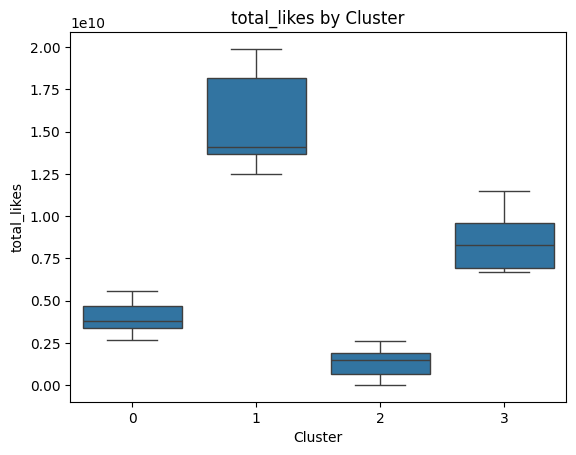

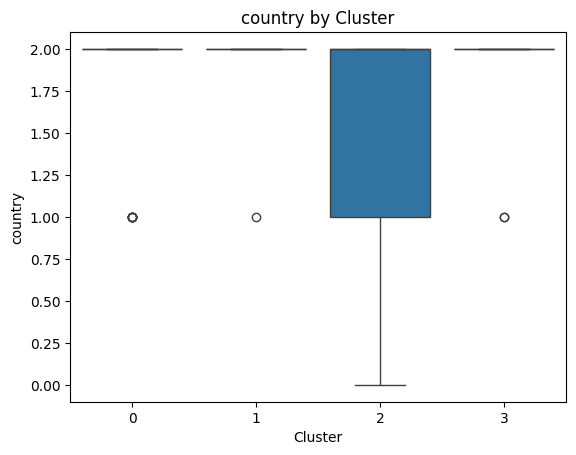

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(dataset_num)
dataset_cluster = dataset
dataset_cluster['Cluster'] = clusters

# Verificar importância visualizando distribuições por cluster
for col in ['influence', 'posts', 'followers', 'avg_new_likes','eng_rate','total_likes','country']:

  sns.boxplot(x='Cluster', y=col, data=dataset_cluster)
  plt.title(col+" by Cluster")
  plt.show()

<Axes: >

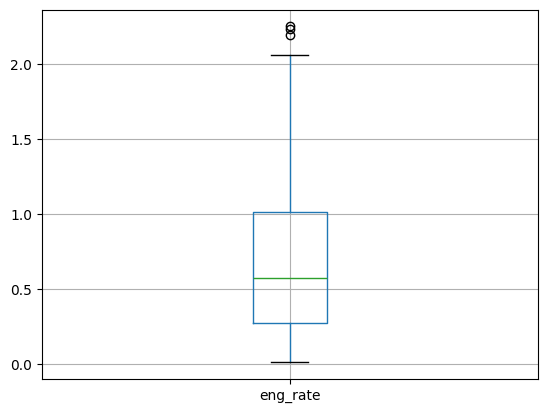

In [ ]:
dataset_cluster.boxplot(column=['eng_rate'])

## KNN - CLASSIFICAÇÃO

In [ ]:
dataset_cluster

,rank,account,influence,posts,followers,avg_likes,eng_rate,avg_new_likes,total_likes,country,Cluster
3,4,selenagomez,93,1800.0,342700000.0,6200000.0,0.97,3300000.0,1.150000e+10,2.0,3
4,5,therock,91,6800.0,334100000.0,1900000.0,0.20,665300.0,1.250000e+10,2.0,1
5,6,kimkardashian,91,5600.0,329200000.0,3500000.0,0.88,2900000.0,1.990000e+10,2.0,1
6,7,arianagrande,92,5000.0,327700000.0,3700000.0,1.20,3900000.0,1.840000e+10,2.0,1
7,8,beyonce,92,2000.0,272800000.0,3600000.0,0.76,2000000.0,7.400000e+09,2.0,3
...,...,...,...,...,...,...,...,...,...,...,...
195,196,iambeckyg,71,2300.0,33200000.0,623800.0,1.40,464700.0,1.400000e+09,2.0,2
196,197,nancyajram,81,3800.0,33200000.0,390400.0,0.64,208000.0,1.500000e+09,2.0,2
197,198,luansantana,79,770.0,33200000.0,193300.0,0.26,82600.0,1.492000e+08,1.0,2
198,199,nickjonas,78,2300.0,33000000.0,719600.0,1.42,467700.0,1.700000e+09,2.0,2


Scores de cada fold: [1.         0.9375     1.         1.         1.         1.
 0.86666667]
Acurácia média: 0.97
Scores de cada fold: [1.         1.         1.         0.9375     0.9375     1.
 0.93333333]
Acurácia média: 0.97
Scores de cada fold: [1.         0.9375     1.         1.         0.9375     1.
 0.86666667]
Acurácia média: 0.96
Scores de cada fold: [1.         0.9375     1.         1.         0.9375     0.9375
 0.86666667]
Acurácia média: 0.95
Scores de cada fold: [1.     0.9375 1.     1.     0.875  0.9375 0.8   ]
Acurácia média: 0.94
Scores de cada fold: [1.     0.9375 0.9375 1.     0.875  0.875  0.8   ]
Acurácia média: 0.92
Scores de cada fold: [1.     0.9375 0.9375 1.     0.875  0.8125 0.8   ]
Acurácia média: 0.91
Scores de cada fold: [0.9375 0.9375 0.9375 1.     0.75   0.8125 0.8   ]
Acurácia média: 0.88
Scores de cada fold: [0.9375 0.9375 0.9375 0.9375 0.75   0.75   0.8   ]
Acurácia média: 0.86
Scores de cada fold: [0.9375     0.9375     0.9375     0.9375     0.625    

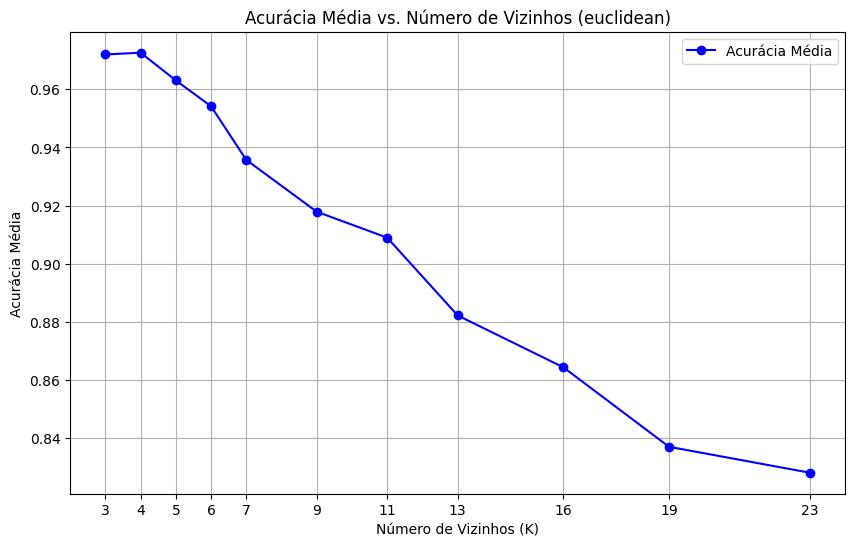

In [ ]:

#Dividindo as categorias geradas pelo clusters em dados e rótulos
dataset_D = dataset_cluster.drop(columns=['Cluster','account'])
dataset_R=dataset_cluster['Cluster']
kf = KFold(n_splits=7, shuffle=True, random_state=1)  # Teste vários n folds
neighbors = [3,4,5,6,7,9,11,13,16,19,23]
accuracy_means = []
for n in neighbors:
  modelo = knn = KNeighborsClassifier(n_neighbors=n, metric='euclidean')
  scores = cross_val_score(modelo, dataset_D, dataset_R, cv=kf, scoring='accuracy')
  print(f"Scores de cada fold: {scores}")
  print(f"Acurácia média: {scores.mean():.2f}")
  accuracy_means.append(scores.mean())
plt.figure(figsize=(10, 6))
plt.plot(neighbors, accuracy_means, marker='o', linestyle='-', color='b', label='Acurácia Média')
plt.title('Acurácia Média vs. Número de Vizinhos (euclidean)')
plt.xlabel('Número de Vizinhos (K)')
plt.ylabel('Acurácia Média')
plt.grid(True)
plt.xticks(neighbors)
plt.legend()
plt.show()

Scores de cada fold: [1.         0.9375     1.         1.         1.         1.
 0.86666667]
Acurácia média: 0.97
Scores de cada fold: [1.         1.         1.         0.9375     0.9375     1.
 0.93333333]
Acurácia média: 0.97
Scores de cada fold: [1.         0.9375     1.         1.         0.9375     1.
 0.86666667]
Acurácia média: 0.96
Scores de cada fold: [1.         0.9375     1.         1.         0.9375     0.9375
 0.86666667]
Acurácia média: 0.95
Scores de cada fold: [1.     0.9375 1.     1.     0.875  0.9375 0.8   ]
Acurácia média: 0.94
Scores de cada fold: [1.     0.9375 0.9375 1.     0.875  0.875  0.8   ]
Acurácia média: 0.92
Scores de cada fold: [1.     0.9375 0.9375 1.     0.875  0.8125 0.8   ]
Acurácia média: 0.91
Scores de cada fold: [0.9375 0.9375 0.9375 1.     0.75   0.8125 0.8   ]
Acurácia média: 0.88
Scores de cada fold: [0.9375 0.9375 0.9375 0.9375 0.75   0.75   0.8   ]
Acurácia média: 0.86
Scores de cada fold: [0.9375     0.9375     0.9375     0.9375     0.625    

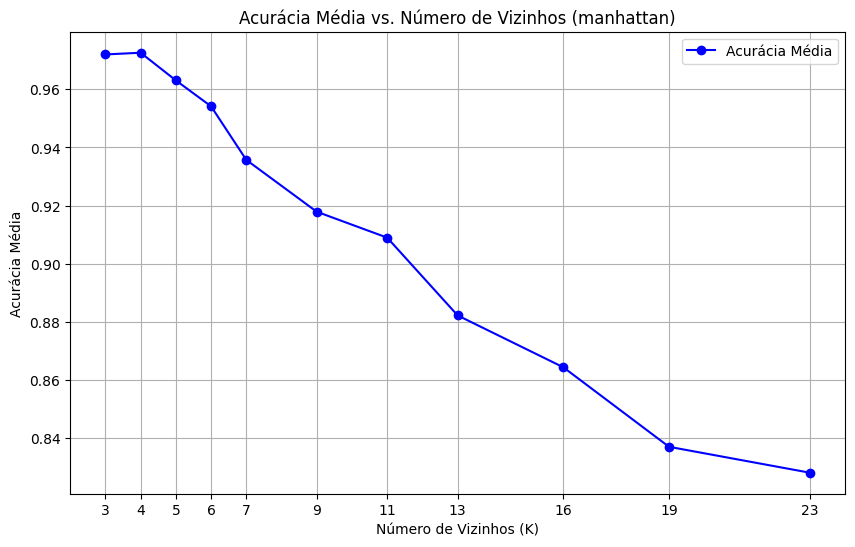

In [ ]:
accuracy_means = []
for n in neighbors:
  modelo = knn = KNeighborsClassifier(n_neighbors=n, metric='manhattan')
  scores = cross_val_score(modelo, dataset_D, dataset_R, cv=kf, scoring='accuracy')
  print(f"Scores de cada fold: {scores}")
  print(f"Acurácia média: {scores.mean():.2f}")
  accuracy_means.append(scores.mean())
plt.figure(figsize=(10, 6))
plt.plot(neighbors, accuracy_means, marker='o', linestyle='-', color='b', label='Acurácia Média')
plt.title('Acurácia Média vs. Número de Vizinhos (manhattan)')
plt.xlabel('Número de Vizinhos (K)')
plt.ylabel('Acurácia Média')
plt.grid(True)
plt.xticks(neighbors)
plt.legend()
plt.show()

Scores de cada fold: [1.         0.9375     1.         1.         1.         1.
 0.86666667]
Acurácia média: 0.97
Scores de cada fold: [1.         1.         1.         0.9375     0.9375     1.
 0.93333333]
Acurácia média: 0.97
Scores de cada fold: [1.         0.9375     1.         1.         0.9375     1.
 0.86666667]
Acurácia média: 0.96
Scores de cada fold: [1.         0.9375     1.         1.         0.9375     0.9375
 0.86666667]
Acurácia média: 0.95
Scores de cada fold: [1.     0.9375 1.     1.     0.875  0.9375 0.8   ]
Acurácia média: 0.94
Scores de cada fold: [1.     0.9375 0.9375 1.     0.875  0.875  0.8   ]
Acurácia média: 0.92
Scores de cada fold: [1.     0.9375 0.9375 1.     0.875  0.8125 0.8   ]
Acurácia média: 0.91
Scores de cada fold: [0.9375 0.9375 0.9375 1.     0.75   0.8125 0.8   ]
Acurácia média: 0.88
Scores de cada fold: [0.9375 0.9375 0.9375 0.9375 0.75   0.75   0.8   ]
Acurácia média: 0.86
Scores de cada fold: [0.9375     0.9375     0.9375     0.9375     0.625    

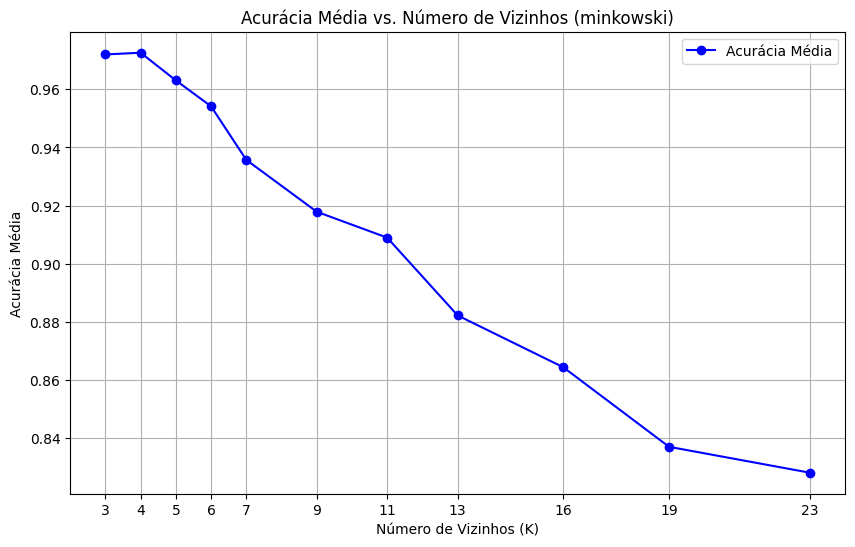

In [ ]:
accuracy_means = []
for n in neighbors:
  modelo = knn = KNeighborsClassifier(n_neighbors=n, metric='minkowski')
  scores = cross_val_score(modelo, dataset_D, dataset_R, cv=kf, scoring='accuracy')
  print(f"Scores de cada fold: {scores}")
  print(f"Acurácia média: {scores.mean():.2f}")
  accuracy_means.append(scores.mean())
plt.figure(figsize=(10, 6))
plt.plot(neighbors, accuracy_means, marker='o', linestyle='-', color='b', label='Acurácia Média')
plt.title('Acurácia Média vs. Número de Vizinhos (minkowski)')
plt.xlabel('Número de Vizinhos (K)')
plt.ylabel('Acurácia Média')
plt.grid(True)
plt.xticks(neighbors)
plt.legend()
plt.show()

A predição do cluster com KNN foi excelente, em todas as métricas excedeu 90%, possuindo melhores valores com k = 3,4 ou 5. Com k=4 pudemos observar 97% de acerto em distância euclidiana, manhattan e minkowski com k=3.

## KNN - REGRESSÃO

In [ ]:
#Vou manter a clusterização aqui e tentar prevendo eng_rate
dataset_D = dataset.drop(columns=['account','eng_rate'])
dataset_R = dataset['eng_rate']
dataset_D_train, dataset_D_test, dataset_R_train, dataset_R_test = train_test_split(dataset_D, dataset_R, test_size=0.2, random_state=42)
#Grid Search
param_grid = {'n_neighbors': np.arange(1, 31),'metric': ['manhattan', 'euclidean', 'minkowski'] }
knn = KNeighborsRegressor()
#Procurando melhores paremetros
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1,)
grid_search.fit(dataset_D_train, dataset_R_train)
print("Melhor k:", grid_search.best_params_['n_neighbors'])
print("Melhor métrica:", grid_search.best_params_['metric'])
print("Melhor MSE (negativo):", grid_search.best_score_)
#Avaliação com os melhores paremetros
best_knn = grid_search.best_estimator_
dataset_R_resultado = best_knn.predict(dataset_D_test)

mae = mean_absolute_error(dataset_R_test, dataset_R_resultado)
mse = mean_squared_error(dataset_R_test, dataset_R_resultado)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Melhor k: 30
Melhor métrica: manhattan
Melhor MSE (negativo): -0.33073961241830063
MAE: 0.46901449275362317
MSE: 0.3153054396135265
RMSE: 0.5615206493206875


Tivemos um bom desempenho prevendo o eng_rate.O MSE penaliza grandes erros, com valor de 0,315 está aceitável acredito, indicando que não há outliers graves. O MAE também está em 0.469, as previsões estão desviando cerca de 23.45% (0.469 / 2) do valor real, o que pode ser aceitável nesse contexto com poucos dados. O RMSE como está abaixo de 1, o modelo está razoavelmente ajustado, mas há espaço para melhorias.

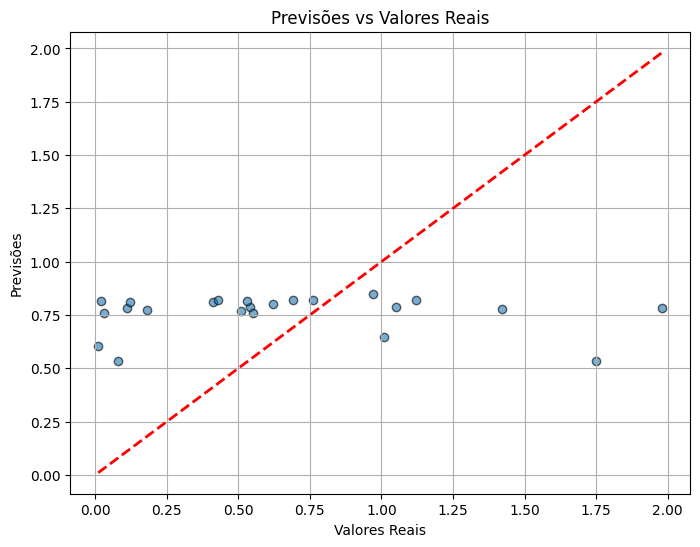

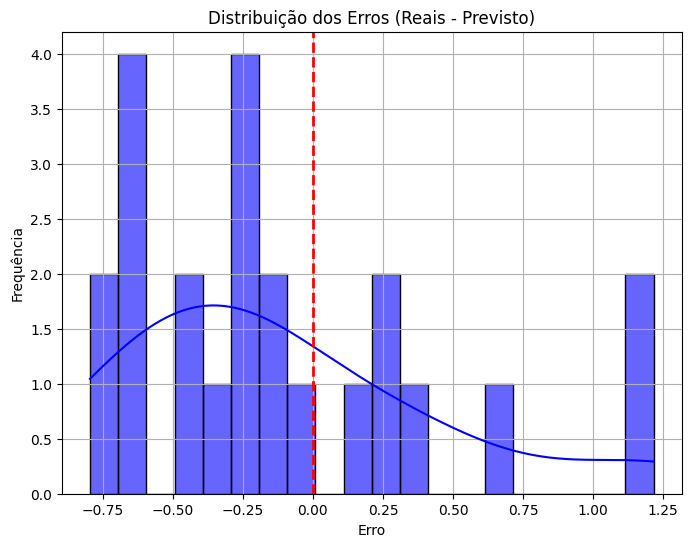

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(dataset_R_test, dataset_R_resultado, alpha=0.6, edgecolors='k')
plt.plot([dataset_R_test.min(), dataset_R_test.max()],
         [dataset_R_test.min(), dataset_R_test.max()],
         color='red', linestyle='--', linewidth=2)
plt.title("Previsões vs Valores Reais")
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.grid(True)
plt.show()

# Gráfico: Distribuição dos Erros
erros = dataset_R_test - dataset_R_resultado
plt.figure(figsize=(8, 6))
sns.histplot(erros, bins=20, kde=True, color='blue', alpha=0.6)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title("Distribuição dos Erros (Reais - Previsto)")
plt.xlabel("Erro")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()